## Import Libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import cv2  # for resizing

# tf and keras
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.utils import class_weight
#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(2)
%matplotlib inline



In [5]:
# If using colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Connect to google drive

In [6]:
target_folder = "207 Machine Learning: Final Project"
found_path = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if target_folder in dirs:
        found_path = os.path.join(root, target_folder)
        break

if found_path:
    os.chdir(found_path)
    print("Changed working directory to:", os.getcwd())
else:
    print(f"Folder '{target_folder}' not found.")

Changed working directory to: /content/drive/.shortcut-targets-by-id/1MnqFmQYij3NcmwhbYUVc-9h4Dp6eLuMH/207 Machine Learning: Final Project


## Load images and labels

In [7]:
# with image, how to classfy image into 2 catogories

# FILL IN CODE HERE #
DATA_PATH = 'Data/Pictures/' # replace with your path

# how to transfer image to array from subfolder

img_size = (128,128) # Resize to smaller dimensions

def load_images_with_labels(folder_path):
    # Load CensusTract -> LILATracts_1And10 mapping

    images = []

    for subfolder in os.listdir(folder_path):
        img_subfolder = os.path.join(folder_path, subfolder)
        if os.path.isdir(img_subfolder):
            for filename in os.listdir(img_subfolder):
                img_path = os.path.join(img_subfolder, filename)
                if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                        img_array = tf.keras.preprocessing.image.img_to_array(img).astype('float32')/255

                        # Extract file_id (assuming filename is CensusTract or similar)
                        file_id = os.path.splitext(filename)[0]
                        # recode image file names
                        tractID = file_id[2:]

                        if file_id.startswith("0_"):
                            file_id = file_id[2:]  # remove the first two chars "0_"
                            y_label = 0
                        if file_id.startswith("1_"):
                            file_id = file_id[2:]  # remove the first two chars "1_"
                            y_label = 1
                        try:
                            file_id = int(file_id)  # convert to integer CensusTract
                        except ValueError:
                            continue  # skip if filename doesn't match a CensusTract format


                        images.append((img_array,y_label,tractID))
                    except Exception as e:
                        print(f"Failed to load {img_path}: {e}")

    return images


In [8]:
#load meta data
centroids_data = pd.read_csv("Data/regional_combined_centroids.csv")
centroids_data.columns.to_list()

['CensusTract',
 'State',
 'County',
 'Urban',
 'Pop2010',
 'OHU2010',
 'GroupQuartersFlag',
 'NUMGQTRS',
 'PCTGQTRS',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'HUNVFlag',
 'LowIncomeTracts',
 'PovertyRate',
 'MedianFamilyIncome',
 'LA1and10',
 'LAhalfand10',
 'LA1and20',
 'LATracts_half',
 'LATracts1',
 'LATracts10',
 'LATracts20',
 'LATractsVehicle_20',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'lapophalfshare',
 'lalowihalf',
 'lalowihalfshare',
 'lakidshalf',
 'lakidshalfshare',
 'laseniorshalf',
 'laseniorshalfshare',
 'lawhitehalf',
 'lawhitehalfshare',
 'lablackhalf',
 'lablackhalfshare',
 'laasianhalf',
 'laasianhalfshare',
 'lanhopihalf',
 'lanhopihalfshare',
 'laaianhalf',
 'laaianhalfshare',
 'laomultirhalf',
 'laomultirhalfshare',
 'lahisphalf',
 'lahisphalfshare',
 'lahunvhalf',
 'lahunvhalfshare',
 'lasnaphalf',
 'lasnaphalfshare',
 'lapop1',
 'lapop1share',
 

In [9]:
#Top 3 important features: ['IsLowIncome' 'NoVehicleHouseholds' 'IsUrban']
#based on random forest model, above features ranking high on importance level


In [10]:
# Load images from the specified folder, get X and y

images = load_images_with_labels(DATA_PATH)
X = np.array([img[0] for img in images], dtype='float32')
Y = np.array([img[1] for img in images],dtype='float32')
tractID = np.array([img[2] for img in images],dtype='int64')


## Split data into training and validation

In [20]:
#split data into training and validation sets

shuffled_index = np.random.permutation(len(X))
X, Y = X[shuffled_index], Y[shuffled_index]

# set up lookup by file_name from image
type(centroids_data['CensusTract'][0])
#centroid_lookup = dict(zip(centroids_data['CensusTract'], centroids_data[['LowIncomeTracts','TractHUNV','Urban']].values))
centroid_lookup = dict(zip(centroids_data['CensusTract'], centroids_data[['LowIncomeTracts']].values))


In [21]:
# Map file_name → LowIncomeTracts (or default to 0.0 if not found)
centroid_features = np.array(
    [centroid_lookup.get(fid, 0.0) for fid in tractID],  # Default to 0.0 if not found
    dtype='float32'
)

# If you're using centroid_features:
centroid_features = centroid_features[shuffled_index]

# 80% train, 20% temp (will split temp later into val and test)
X_train, X_temp, Y_train, Y_temp, centroids_train, centroids_temp = train_test_split(
    X, Y, centroid_features, test_size=0.2, random_state=42
)

X_val, X_test, Y_val, Y_test, centroids_val, centroids_test = train_test_split(
    X_temp, Y_temp, centroids_temp, test_size=0.5, random_state=42
)

In [22]:

print("The shapes of X_train is", X_train.shape)
print("The shapes of Y_train is",Y_train.shape)
print("The shapes of X_val is",X_val.shape)
print("The shapes of Y_val is",Y_val.shape)
print("The shapes of X_test is",X_test.shape)
print("The shapes of Y_test is",Y_test.shape)

print("The type if X_train is", type(X_train))
print("The type if Y_train is", type(Y_train))
print("The type if X_val is", type(X_val))
print("The type if Y_val is", type(Y_val))
print("The shapes of X_test is",type(X_test))
print("The shapes of Y_test is",type(Y_test))

print("The type if centroids_train is", type(centroids_train))
print("The type if centroids validation is", type(centroids_val))
print("The shapes of centroids test is",type(centroids_test))



The shapes of X_train is (5696, 128, 128, 3)
The shapes of Y_train is (5696,)
The shapes of X_val is (712, 128, 128, 3)
The shapes of Y_val is (712,)
The shapes of X_test is (713, 128, 128, 3)
The shapes of Y_test is (713,)
The type if X_train is <class 'numpy.ndarray'>
The type if Y_train is <class 'numpy.ndarray'>
The type if X_val is <class 'numpy.ndarray'>
The type if Y_val is <class 'numpy.ndarray'>
The shapes of X_test is <class 'numpy.ndarray'>
The shapes of Y_test is <class 'numpy.ndarray'>
The type if centroids_train is <class 'numpy.ndarray'>
The type if centroids validation is <class 'numpy.ndarray'>
The shapes of centroids test is <class 'numpy.ndarray'>


In [23]:
# Min-Max normalization
min_vals = centroids_train.min(axis=0)
max_vals = centroids_train.max(axis=0)

def normalize(data, min_vals, max_vals):
    # Avoid division by zero
    denom = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
    return (data - min_vals) / denom

# Normalize train, val, and test sets
centroids_train_norm = normalize(centroids_train, min_vals, max_vals)
centroids_val_norm   = normalize(centroids_val, min_vals, max_vals)
centroids_test_norm  = normalize(centroids_test, min_vals, max_vals)


## CNN base line based on majority class

In [24]:
# Baseline
# When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

print("1. The number of food desert in Y_train is",np.sum(Y_train==1))
print("2. The number of non-food desert in Y_train_mini is",np.sum(Y_train!=1))
print("3. The majority class in Y_train is non-food desert class.")
print("4. The accuracy of a majority class classifier for Y_train is", round(np.sum(Y_train!=1)/(np.sum(Y_train!=1)+np.sum(Y_train==1)),4))

1. The number of food desert in Y_train is 1232
2. The number of non-food desert in Y_train_mini is 4464
3. The majority class in Y_train is non-food desert class.
4. The accuracy of a majority class classifier for Y_train is 0.7837


## Build CNN model

In [25]:
# early stop setup
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
import tensorflow as tf

def create_cnn_model(input_shape):
    # Image input
    image_input = tf.keras.Input(shape=input_shape, name='image_input')

    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(image_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)

    # Add metadata input: centroid_x
    meta_input = tf.keras.Input(shape=(1,), name='meta_input')
    meta_dense = tf.keras.layers.Dense(8, activation='relu')(meta_input)

    # Concatenate CNN features with metadata
    combined = tf.keras.layers.Concatenate()([x, meta_dense])
    combined = tf.keras.layers.Dense(64, activation='relu')(combined)
    combined = tf.keras.layers.Dropout(0.2)(combined)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)

    # Define the model
    model = tf.keras.Model(inputs=[image_input, meta_input], outputs=output)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [26]:
# train the model
input_shape = (128, 128, 3) # Assume the images are 400*400 with RGB colors
number_of_classes  = 1 # binary classfication
model = create_cnn_model(input_shape=input_shape)


history = model.fit(
    x={
        'image_input': X_train,        # shape: (N, H, W, C)
        'meta_input': centroids_train_norm  # shape: (N, features)
    },
    y=Y_train,
    validation_data=({
        'image_input': X_val,
        'meta_input': centroids_val_norm
    }, Y_val),
    #class_weight=class_weight_dict,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7289 - loss: 1.4436 - val_accuracy: 0.2219 - val_loss: 10.7434
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7830 - loss: 0.6665 - val_accuracy: 0.5126 - val_loss: 0.9023
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7809 - loss: 0.6463 - val_accuracy: 0.7570 - val_loss: 0.6481
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7906 - loss: 0.6262 - val_accuracy: 0.7781 - val_loss: 0.6177
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7904 - loss: 0.6100 - val_accuracy: 0.7781 - val_loss: 0.6040
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7873 - loss: 0.5973 - val_accuracy: 0.7781 - val_loss: 0.5922
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7850 - loss: 0.5862 - val_accuracy: 0.7781 - val_loss: 0.5818
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7799 - loss: 0.5784 - val_acc

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7698 - loss: 0.5405
Validation Loss: 0.5314, Validation Accuracy: 0.7781


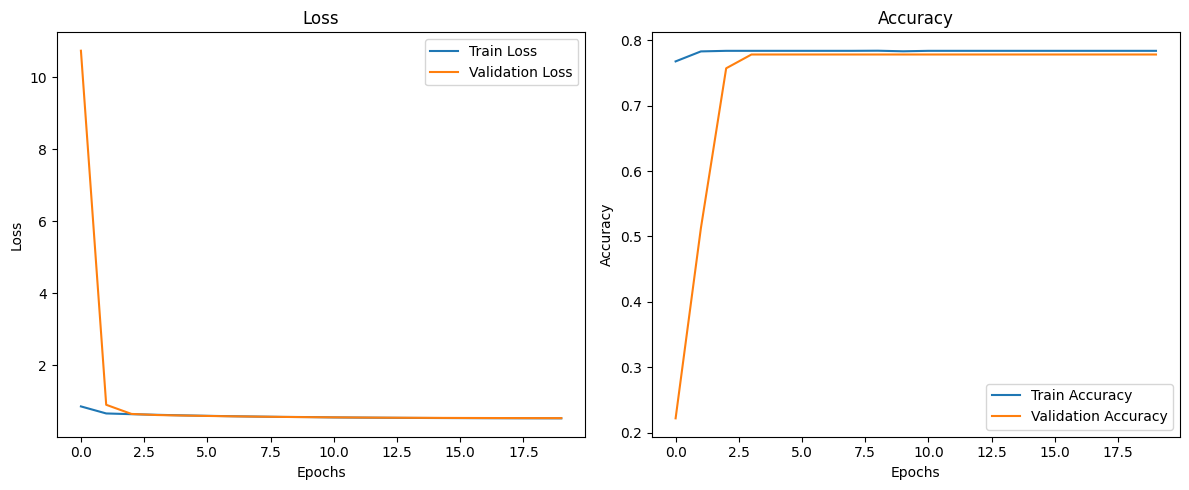

In [27]:
# Evaluate the model
loss,accuracy = model.evaluate({
        'image_input': X_val,        # shape: (N, H, W, C)
        'meta_input': centroids_val # shape: (N, 1)
    },Y_val,verbose=1)

print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# draw the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


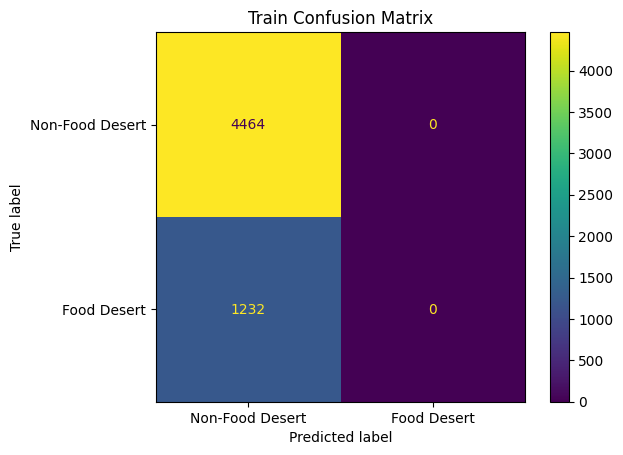

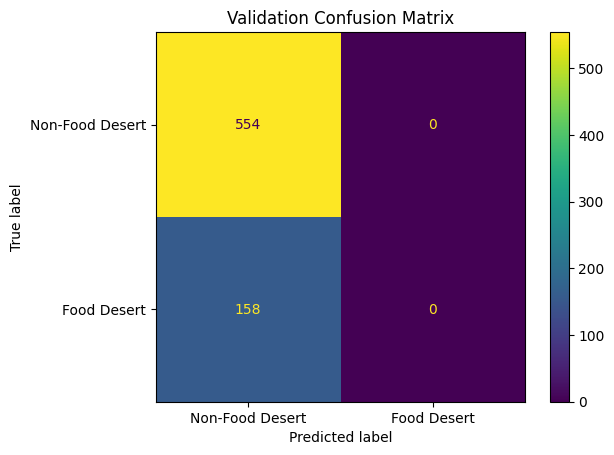

Training Data Results:
True Positives training (TP): 0
False Negatives training(FN): 1232
False Positives training(FP): 0
True Negatives training(TN): 4464
Validation Data Results:
True Positives validation (TP): 0
False Negatives validation(FN): 158
False Positives validation(FP): 0
True Negatives validation(TN): 554
The model does not have generalization capabilities. The accuracy are quite different between training and validation dataset.The training accuracy is nan. The testing accuracy is nan


In [28]:
Y_train_pred = model.predict({
        'image_input': X_train,
        'meta_input': centroids_train_norm
    })
Y_train_pred_classes = (Y_train_pred >= 0.5).astype(int)

Y_val_pred = model.predict({
        'image_input': X_val,
        'meta_input': centroids_val_norm
    })
Y_val_pred_classes = (Y_val_pred >= 0.5).astype(int)

train_cm = confusion_matrix(Y_train,Y_train_pred_classes)
table_validation= ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Non-Food Desert', 'Food Desert'])
table_validation.plot()
table_validation.ax_.set_title('Train Confusion Matrix')
plt.show()

validation_cm = confusion_matrix(Y_val,Y_val_pred_classes)
table_validation= ConfusionMatrixDisplay(confusion_matrix=validation_cm, display_labels=['Non-Food Desert', 'Food Desert'])
table_validation.plot()
table_validation.ax_.set_title('Validation Confusion Matrix')
plt.show()

# Training Confusion Matrix
TN_training, FP_training, FN_training, TP_training = train_cm.ravel()
print("Training Data Results:")
print(f"True Positives training (TP): {TP_training}")
print(f"False Negatives training(FN): {FN_training}")
print(f"False Positives training(FP): {FP_training}")
print(f"True Negatives training(TN): {TN_training}")

# Validation Confusion Matrix
TN_validation, FP_validation, FN_validation, TP_validation = validation_cm.ravel()
print("Validation Data Results:")
print(f"True Positives validation (TP): {TP_validation}")
print(f"False Negatives validation(FN): {FN_validation}")
print(f"False Positives validation(FP): {FP_validation}")
print(f"True Negatives validation(TN): {TN_validation}")


accuracy_training_tp = (TP_training/(TP_training+FP_training))
accuracy_validation_tp = (TP_validation/(TP_validation+FP_validation))
print(f"The model does not have generalization capabilities. The accuracy are quite different between training and validation dataset.The training accuracy is {accuracy_training_tp:.2f}. The testing accuracy is {accuracy_validation_tp:.2f}")

